# Import Libraries

In [3]:
pip install -q -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [2]:
import os
import tensorflow.keras
from keras.constraints import maxnorm
import tensorflow.keras
from tensorflow.keras.models import Model
#import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout,BatchNormalization,Activation
import math
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix
from skimage import io
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report , confusion_matrix , plot_roc_curve , plot_confusion_matrix
from sklearn.metrics import accuracy_score , precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from statistics import mode
import tensorflow as tf
from sklearn.neural_network import MLPClassifier
from skimage import filters
import time
from sklearn.metrics import mean_squared_error
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
# from tensorflow.keras import backend as K

# Load Data

In [3]:
def load_images(data_path):
  #store images and class of each image
  images = []
  classes = []
  dirs = os.listdir(data_path)
  # looping over the folder sub folders
  for folder_name in sorted(dirs):
    #looping over all images in the subfodler class
      for file in os.listdir(data_path+'/'+folder_name):
          image = io.imread(data_path+'/'+folder_name+'/'+file)
          image = cv2.resize(image, (32,32))
          folder = int(folder_name)
          images.append(image)
          classes.append(folder)     
  return images,classes

In [4]:
train_dir = 'training'
test_dir = 'testing'

train_x,train_y = load_images(train_dir)
X_test,y_test = load_images(test_dir)

## Display The Dataset

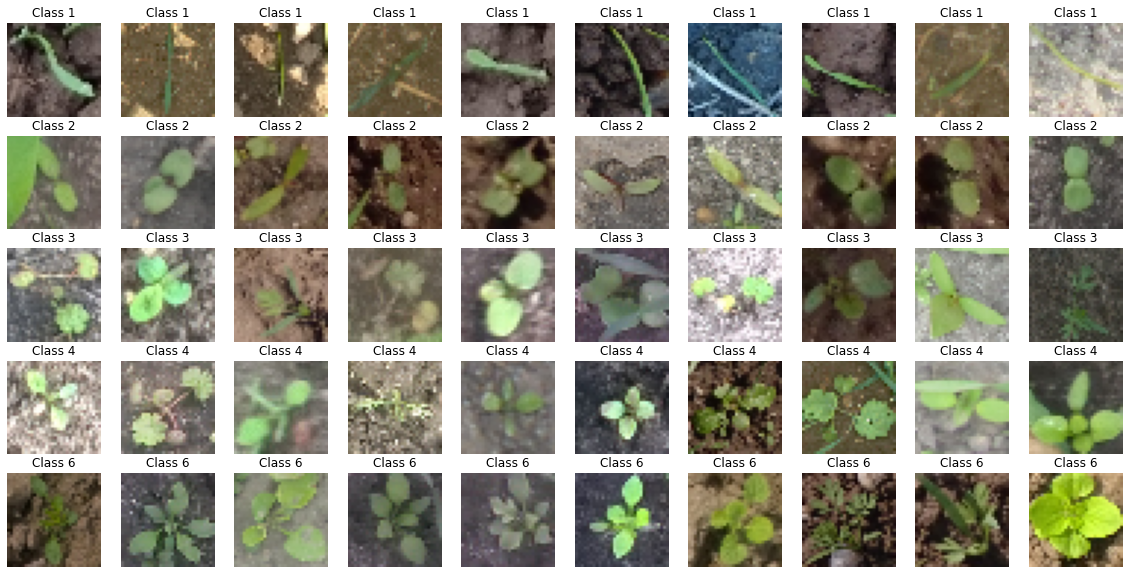

In [6]:
f, axarr = plt.subplots(5,10)
f.set_figheight(10)
f.set_figwidth(20)
for j in range(10):

    axarr[0,j].set_title("Class 1" ,fontsize=12)
    axarr[0,j].imshow(train_x[j])
    axarr[0,j].axis('off')

    axarr[1,j].set_title("Class 2" ,fontsize=12)
    axarr[1,j].imshow(train_x[j+180])
    axarr[1,j].axis('off')

    axarr[2,j].set_title("Class 3" ,fontsize=12)
    axarr[2,j].imshow(train_x[j+(2*180)])
    axarr[2,j].axis('off')

    axarr[3,j].set_title("Class 4" ,fontsize=12)
    axarr[3,j].imshow(train_x[j+(3*180)])
    axarr[3,j].axis('off')

    axarr[4,j].set_title("Class 6" ,fontsize=12)
    axarr[4,j].imshow(train_x[j+(4*180)])
    axarr[4,j].axis('off')


## Split the training set to train and validate

In [7]:
X_train , X_validate , y_train, y_validate = train_test_split(train_x,train_y , test_size=0.33, random_state=20 , stratify=train_y)

# Basic Transfer Learning

## Import VGG

In [8]:
from tensorflow.keras.applications import VGG16
vgg_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(32, 32, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [9]:
print(vgg_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [10]:
X_train = np.array(X_train)
X_validate = np.array(X_validate)
X_test = np.array(X_test)

In [11]:
def transform_labels(arr):
  for i in range(len(arr)):
    if arr[i] == 6:
      arr[i]= 4
    elif arr[i] == 4:
      arr[i]= 3
    elif arr[i] == 3:
      arr[i]= 2
    elif arr[i] == 2:
      arr[i]= 1
    else: 
      arr[i]= 0
  return arr

In [12]:
train_x = np.array(train_x)
train_y = transform_labels(train_y)

## Classification Network

In [13]:
y_train_class = transform_labels(y_train)
y_validate_class = transform_labels(y_validate)
y_test_class = transform_labels(y_test)

In [14]:
nClasses = 5
y_train_k = tensorflow.keras.utils.to_categorical(y_train_class, num_classes=nClasses)
y_validate_k = tensorflow.keras.utils.to_categorical(y_validate_class, num_classes=nClasses)
y_test_k = tensorflow.keras.utils.to_categorical(y_test_class, num_classes=nClasses)

In [ ]:
for layer in vgg_model.layers:
    layer.trainable = False

x = vgg_model.layers[6].output
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = Dense(5, activation='softmax')(x)
vgg_model_transfer_classification = Model(inputs=vgg_model.input, outputs=x)
print(vgg_model_transfer_classification.summary())

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0  

In [ ]:
batchSize = 128
nEpochs = 40

adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
vgg_model_transfer_classification.compile(loss='categorical_crossentropy', 
                           optimizer=adam, 
                           metrics=['accuracy'])
                           
history = vgg_model_transfer_classification.fit(X_train, y_train_k, batch_size=batchSize, epochs=nEpochs, verbose=1, 
                                 validation_data=(X_validate, y_validate_k))

Epoch 1/40
5/5 [==============================] - 1s 80ms/step - loss: 1138.8619 - accuracy: 0.2206 - val_loss: 979.0128 - val_accuracy: 0.2155
Epoch 2/40
5/5 [==============================] - 0s 30ms/step - loss: 646.0795 - accuracy: 0.2355 - val_loss: 652.7703 - val_accuracy: 0.1818
Epoch 3/40
5/5 [==============================] - 0s 34ms/step - loss: 402.3585 - accuracy: 0.2902 - val_loss: 497.1303 - val_accuracy: 0.2424
Epoch 4/40
5/5 [==============================] - 0s 32ms/step - loss: 303.7354 - accuracy: 0.3217 - val_loss: 399.3476 - val_accuracy: 0.2088
Epoch 5/40
5/5 [==============================] - 0s 30ms/step - loss: 219.1391 - accuracy: 0.3798 - val_loss: 366.3778 - val_accuracy: 0.2492
Epoch 6/40
5/5 [==============================] - 0s 29ms/step - loss: 173.7644 - accuracy: 0.4328 - val_loss: 340.7341 - val_accuracy: 0.2222
Epoch 7/40
5/5 [==============================] - 0s 27ms/step - loss: 136.4702 - accuracy: 0.4892 - val_loss: 307.1638 - val_accuracy: 0.266

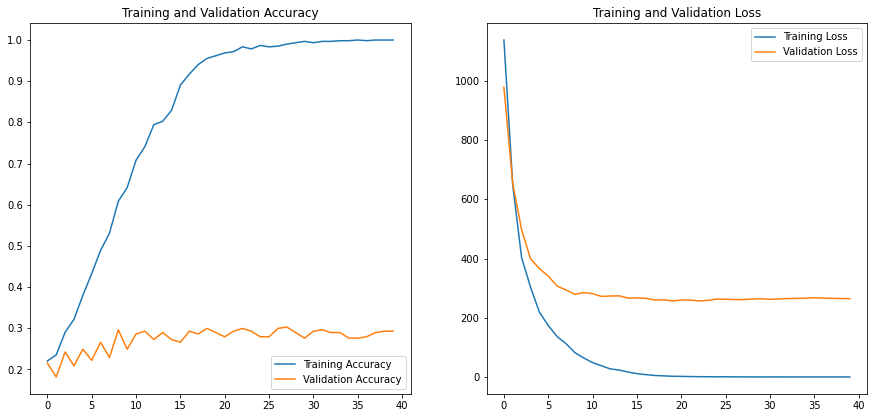

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(nEpochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Confusion matrix on train data

In [ ]:
y_predict_prob = vgg_model_transfer_classification.predict(train_x)
y_predict = y_predict_prob.argmax(axis=-1)

In [ ]:
print(classification_report(train_y,y_predict))

              precision    recall  f1-score   support

           0       0.90      0.82      0.85       180
           1       0.82      0.75      0.78       180
           2       0.67      0.73      0.70       180
           3       0.71      0.73      0.72       180
           4       0.75      0.80      0.78       180

    accuracy                           0.77       900
   macro avg       0.77      0.77      0.77       900
weighted avg       0.77      0.77      0.77       900



In [ ]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(train_y, y_predict)
print('Confusion matrix: \n{0}'.format(conf_mx))

Confusion matrix: 
[[147   5  11  10   7]
 [  6 135  16  17   6]
 [  6  12 132  17  13]
 [  2   7  18 132  21]
 [  3   5  19   9 144]]


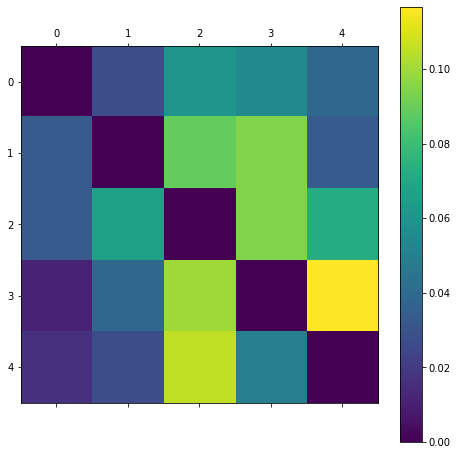

In [ ]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
# plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plot_confusion_matrix(norm_conf_mx)
plt.show()

### Confusion matrix on test data

In [ ]:
y_predict_prob = vgg_model_transfer_classification.predict(X_test)
y_predict = y_predict_prob.argmax(axis=-1)
print(classification_report(y_test_class, y_predict))

              precision    recall  f1-score   support

           0       0.39      0.35      0.37        20
           1       0.25      0.20      0.22        20
           2       0.26      0.35      0.30        20
           3       0.22      0.25      0.23        20
           4       0.25      0.20      0.22        20

    accuracy                           0.27       100
   macro avg       0.27      0.27      0.27       100
weighted avg       0.27      0.27      0.27       100



In [ ]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_test_class, y_predict)
print('Confusion matrix: \n{0}'.format(conf_mx))

Confusion matrix: 
[[7 4 5 3 1]
 [6 4 6 2 2]
 [1 4 7 5 3]
 [2 2 5 5 6]
 [2 2 4 8 4]]


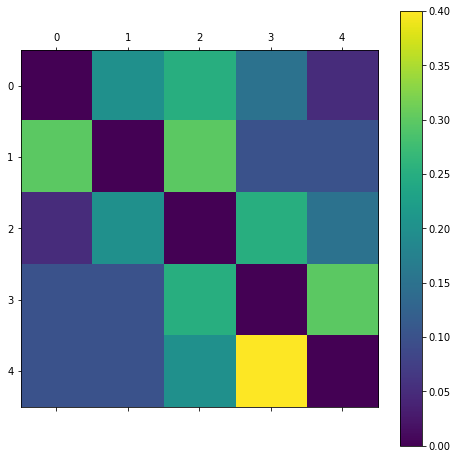

In [ ]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
# plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plot_confusion_matrix(norm_conf_mx)
plt.show()

## Regression Network

In [ ]:
y_train_reg = np.array(y_train).astype(float)
y_validate_reg = np.array(y_validate).astype(float)
y_test_reg = np.array(y_test).astype(float)
train_y_reg = np.array(train_y).astype(float)

In [ ]:
for layer in vgg_model.layers:
        layer.trainable = False

x = vgg_model.layers[6].output
x = Flatten()(x)
x = Dense(100, activation='tanh')(x)
x = Dense(1, activation='relu6')(x)
vgg_model_transfer_regression = Model(inputs=vgg_model.input, outputs=x)
print(vgg_model_transfer_regression.summary())

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0  

In [ ]:
batchSize = 128
nEpochs = 60

sgd = tf.keras.optimizers.SGD(learning_rate=0.0001)
vgg_model_transfer_regression.compile(loss='mean_squared_error'
                           optimizer=sgd)
history_regression = vgg_model_transfer_regression.fit(X_train, y_train_reg, batch_size=batchSize, epochs=nEpochs, verbose=1, 
                                 validation_data=(X_validate, y_validate_reg))

Epoch 1/60
5/5 [==============================] - 1s 76ms/step - loss: 5.2970 - accuracy: 0.2106 - val_loss: 4.0553 - val_accuracy: 0.2222
Epoch 2/60
5/5 [==============================] - 0s 32ms/step - loss: 3.3238 - accuracy: 0.2172 - val_loss: 2.9481 - val_accuracy: 0.2155
Epoch 3/60
5/5 [==============================] - 0s 30ms/step - loss: 2.5766 - accuracy: 0.2156 - val_loss: 2.9277 - val_accuracy: 0.2054
Epoch 4/60
5/5 [==============================] - 0s 29ms/step - loss: 2.4071 - accuracy: 0.2189 - val_loss: 2.8473 - val_accuracy: 0.2088
Epoch 5/60
5/5 [==============================] - 0s 28ms/step - loss: 2.4156 - accuracy: 0.2156 - val_loss: 2.7992 - val_accuracy: 0.2088
Epoch 6/60
5/5 [==============================] - 0s 26ms/step - loss: 2.3765 - accuracy: 0.2156 - val_loss: 2.6742 - val_accuracy: 0.2088
Epoch 7/60
5/5 [==============================] - 0s 26ms/step - loss: 2.2148 - accuracy: 0.2189 - val_loss: 2.5960 - val_accuracy: 0.2088
Epoch 8/60
5/5 [===========

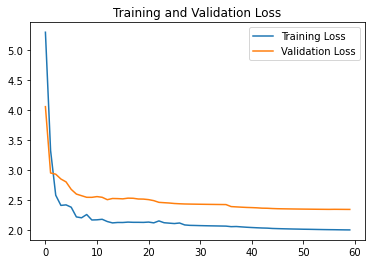

In [ ]:
loss = history_regression.history['loss']
val_loss = history_regression.history['val_loss']

epochs_range = range(nEpochs)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Mean Square Error on Train Dataset

In [ ]:
y_predict = vgg_model_transfer_regression.predict(train_x)
mean_square = mean_squared_error(train_y_reg, y_predict)
print("Mean Square Error on Train Dataset = "+str(mean_square))

Mean Square Error on Train Dataset = 2.1100056453811753


Mean Square Error on Test Dataset

In [ ]:
y_predict = vgg_model_transfer_regression.predict(X_test)
mean_square = mean_squared_error(y_test_reg, y_predict)
print("Mean Square Error on Test Dataset = "+str(mean_square))

Mean Square Error on Test Dataset = 2.2891540453374235


# Discussion [1]

Although The overall performance for both claassification and regression isn't very well unless classification gives us promissing resuts

Both Classification and regression overfit on the train datasets but the problem tends to be classification because we are predicting constant predictions of leave count so it cannot be regression problem

In classification we can see from accuracy that the train accuracy is going crazily to 100% accuracy while the validate accuracy somehow steady between 20% to 30% accuracy which means the model overfits the train dataset

we can fix that by adding another data, adding regularization and applying some data augmentation

In Regression its obvious that the model cannot learn because of the fact that regression deals with continuous values , not probabilistic ones. sensitive to imbalance data when using regression for classification.

# Improve the Model

## Regularization

In [86]:
for layer in vgg_model.layers:
        layer.trainable = False

x = vgg_model.layers[6].output
x = Flatten()(x)
x = Dropout(0.2)(x)
x = tfa.layers.WeightNormalization(Dense(100, activation='relu'))(x)
x = tfa.layers.WeightNormalization(Dense(5, activation='softmax'))(x)
vgg_model_transfer_regularization = Model(inputs=vgg_model.input, outputs=x)
print(vgg_model_transfer_regularization.summary())

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0  

In [35]:
batchSize = 128
nEpochs = 20

adam = tf.keras.optimizers.Adam(learning_rate=0.1)
vgg_model_transfer_regularization.compile(loss='categorical_crossentropy', 
                           optimizer=adam, 
                           metrics=['accuracy'])

history_regularization = vgg_model_transfer_regularization.fit(X_train, y_train_k, batch_size=batchSize, epochs=nEpochs, verbose=1, 
                                 validation_data=(X_validate, y_validate_k))

Epoch 1/20
5/5 [==============================] - 2s 135ms/step - loss: 13976.4697 - accuracy: 0.1973 - val_loss: 7902.2729 - val_accuracy: 0.1414
Epoch 2/20
5/5 [==============================] - 0s 39ms/step - loss: 6843.9106 - accuracy: 0.1857 - val_loss: 4963.0459 - val_accuracy: 0.2020
Epoch 3/20
5/5 [==============================] - 0s 33ms/step - loss: 4184.8174 - accuracy: 0.2090 - val_loss: 2935.3760 - val_accuracy: 0.2121
Epoch 4/20
5/5 [==============================] - 0s 38ms/step - loss: 1483.7834 - accuracy: 0.2388 - val_loss: 1099.0339 - val_accuracy: 0.2492
Epoch 5/20
5/5 [==============================] - 0s 36ms/step - loss: 659.0671 - accuracy: 0.3134 - val_loss: 414.2085 - val_accuracy: 0.2492
Epoch 6/20
5/5 [==============================] - 0s 30ms/step - loss: 282.1461 - accuracy: 0.3234 - val_loss: 179.2189 - val_accuracy: 0.2492
Epoch 7/20
5/5 [==============================] - 0s 29ms/step - loss: 93.9972 - accuracy: 0.3449 - val_loss: 92.4150 - val_accuracy

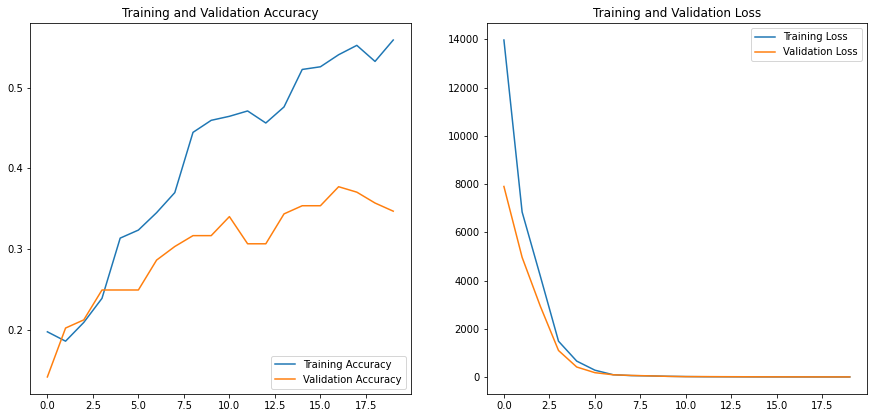

In [36]:
acc = history_regularization.history['accuracy']
val_acc = history_regularization.history['val_accuracy']
loss = history_regularization.history['loss']
val_loss = history_regularization.history['val_loss']

epochs_range = range(nEpochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Confusion matrix on train data

In [37]:
y_predict_prob = vgg_model_transfer_regularization.predict(train_x)
y_predict = y_predict_prob.argmax(axis=-1)

In [38]:
print(classification_report(train_y,y_predict))

              precision    recall  f1-score   support

           0       0.67      0.57      0.61       180
           1       0.51      0.61      0.55       180
           2       0.50      0.39      0.44       180
           3       0.52      0.48      0.50       180
           4       0.34      0.44      0.39       180

    accuracy                           0.50       900
   macro avg       0.51      0.50      0.50       900
weighted avg       0.51      0.50      0.50       900



In [39]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(train_y, y_predict)
print('Confusion matrix: \n{0}'.format(conf_mx))

Confusion matrix: 
[[102  24   9   5  40]
 [ 21 109  18  10  22]
 [ 17  32  70  11  50]
 [  6  34  15  86  39]
 [  7  14  28  52  79]]


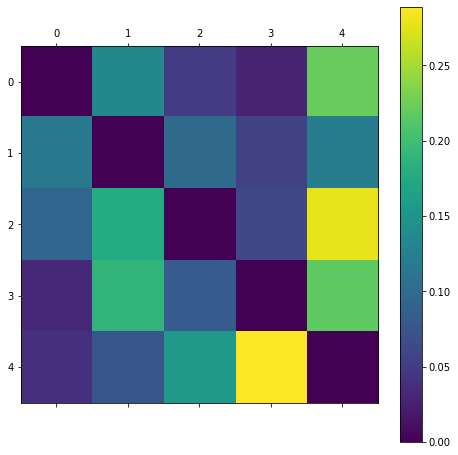

In [40]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
# plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plot_confusion_matrix(norm_conf_mx)
plt.show()

### Confusion matrix on test data

In [41]:
y_predict_prob = vgg_model_transfer_regularization.predict(X_test)
y_predict = y_predict_prob.argmax(axis=-1)
print(classification_report(y_test_class, y_predict))

              precision    recall  f1-score   support

           0       0.56      0.50      0.53        20
           1       0.29      0.30      0.29        20
           2       0.15      0.15      0.15        20
           3       0.29      0.20      0.24        20
           4       0.11      0.15      0.13        20

    accuracy                           0.26       100
   macro avg       0.28      0.26      0.27       100
weighted avg       0.28      0.26      0.27       100



In [42]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_test_class, y_predict)
print('Confusion matrix: \n{0}'.format(conf_mx))

Confusion matrix: 
[[10  3  0  1  6]
 [ 3  6  4  0  7]
 [ 3  7  3  3  4]
 [ 0  3  6  4  7]
 [ 2  2  7  6  3]]


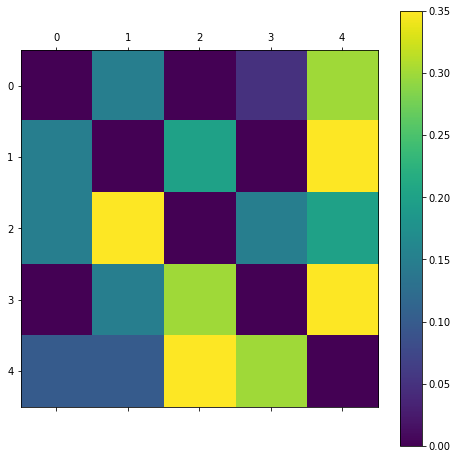

In [43]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
# plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plot_confusion_matrix(norm_conf_mx)
plt.show()

## Data Augmentation

In [65]:
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True)

datagen.fit(X_train)

In [75]:
for layer in vgg_model.layers:
        layer.trainable = False

x = vgg_model.layers[6].output
x = Flatten()(x)
x = Dropout(0.2)(x)
x = tfa.layers.WeightNormalization(Dense(100, activation='relu'))(x)
x = tfa.layers.WeightNormalization(Dense(5, activation='softmax'))(x)

vgg_model_transfer_augmentation = Model(inputs=vgg_model.input, outputs=x)
print(vgg_model_transfer_augmentation.summary())

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0  

In [76]:
train_aug = datagen.flow(X_train,y_train_k,batch_size=20,shuffle=True)
val_aug = datagen.flow(X_validate,y_validate_k,batch_size=20,shuffle=True)

In [77]:
nEpochs = 20

adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
vgg_model_transfer_augmentation.compile(loss='categorical_crossentropy', 
                           optimizer=adam, 
                           metrics=['accuracy'])

history_augmentation = vgg_model_transfer_augmentation.fit(train_aug,epochs=nEpochs, verbose=1,
                                 validation_data=val_aug)

Epoch 1/20
31/31 [==============================] - 3s 41ms/step - loss: 1.7412 - accuracy: 0.2620 - val_loss: 1.5502 - val_accuracy: 0.3232
Epoch 2/20
31/31 [==============================] - 1s 27ms/step - loss: 1.4888 - accuracy: 0.3831 - val_loss: 1.4973 - val_accuracy: 0.3434
Epoch 3/20
31/31 [==============================] - 1s 28ms/step - loss: 1.4421 - accuracy: 0.3947 - val_loss: 1.4782 - val_accuracy: 0.4108
Epoch 4/20
31/31 [==============================] - 1s 28ms/step - loss: 1.3233 - accuracy: 0.4461 - val_loss: 1.3523 - val_accuracy: 0.4310
Epoch 5/20
31/31 [==============================] - 1s 27ms/step - loss: 1.2975 - accuracy: 0.4643 - val_loss: 1.4353 - val_accuracy: 0.3670
Epoch 6/20
31/31 [==============================] - 1s 27ms/step - loss: 1.2096 - accuracy: 0.4942 - val_loss: 1.3993 - val_accuracy: 0.4444
Epoch 7/20
31/31 [==============================] - 1s 26ms/step - loss: 1.1938 - accuracy: 0.5390 - val_loss: 1.3285 - val_accuracy: 0.4175
Epoch 8/20
31

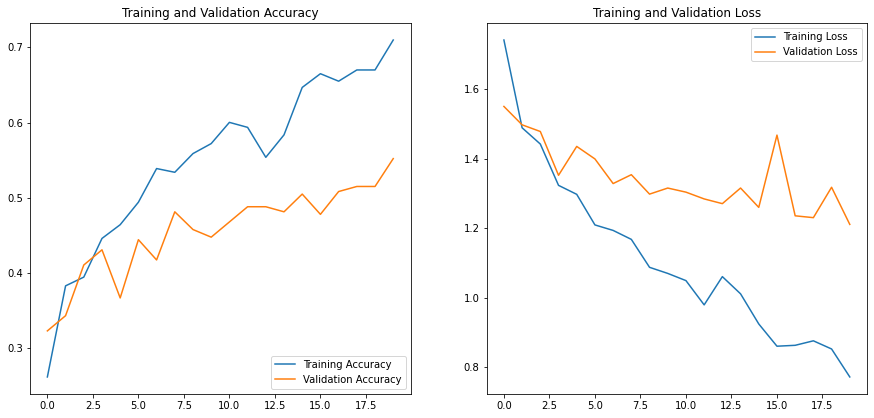

In [78]:
acc = history_augmentation.history['accuracy']
val_acc = history_augmentation.history['val_accuracy']
loss = history_augmentation.history['loss']
val_loss = history_augmentation.history['val_loss']

epochs_range = range(nEpochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Confusion matrix on train data

In [79]:
y_predict_prob = vgg_model_transfer_augmentation.predict(train_x)
y_predict = y_predict_prob.argmax(axis=-1)

In [80]:
print(classification_report(train_y,y_predict))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       180
           1       0.87      0.57      0.69       180
           2       0.53      0.78      0.63       180
           3       0.66      0.60      0.63       180
           4       0.75      0.74      0.75       180

    accuracy                           0.71       900
   macro avg       0.74      0.71      0.71       900
weighted avg       0.74      0.71      0.71       900



In [81]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(train_y, y_predict)
print('Confusion matrix: \n{0}'.format(conf_mx))

Confusion matrix: 
[[154   4  18   3   1]
 [ 12 103  53   8   4]
 [  6   8 141  20   5]
 [  3   2  33 108  34]
 [  1   1  20  24 134]]


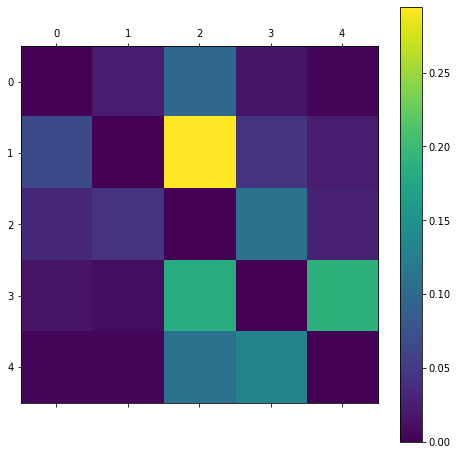

In [82]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
# plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plot_confusion_matrix(norm_conf_mx)
plt.show()

### Confusion matrix on test data

In [83]:
y_predict_prob = vgg_model_transfer_augmentation.predict(X_test)
y_predict = y_predict_prob.argmax(axis=-1)
print(classification_report(y_test_class, y_predict))

              precision    recall  f1-score   support

           0       0.65      0.55      0.59        20
           1       0.64      0.35      0.45        20
           2       0.21      0.45      0.29        20
           3       0.25      0.15      0.19        20
           4       0.61      0.55      0.58        20

    accuracy                           0.41       100
   macro avg       0.47      0.41      0.42       100
weighted avg       0.47      0.41      0.42       100



In [84]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_test_class, y_predict)
print('Confusion matrix: \n{0}'.format(conf_mx))

Confusion matrix: 
[[11  3  6  0  0]
 [ 3  7 10  0  0]
 [ 3  1  9  6  1]
 [ 0  0 11  3  6]
 [ 0  0  6  3 11]]


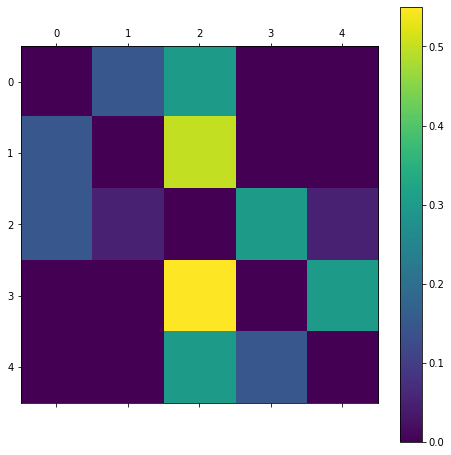

In [85]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
# plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plot_confusion_matrix(norm_conf_mx)
plt.show()

# Discussion [2]

Based on the learning curves, when we applied regularization only on the network using Dropout and WeightNormalization layers the model started to get rid of the overfitting problem when validation and training accuracies were somehow closer to each other than before but regularization didn't fully solved the problem of overfitting.

After applying some data augmentation the accuracy increased from 33% to 41% on the test dataset which indicates the improvment of adding augmented data

The model can classify the class of 1 leaf very good unlike the other plants with higher leafs

I think the model suffer from overfitting because of many things
- the model couldn't learn the difference between the images because they are very simmilar to each other and the color feature didn't add information
- the size of the training dataset is not enough to train on 
- there are much similarities between all images and model couldn't get much features
- limitations of adding conv/full layers